In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch.optim as optim

In [2]:
def data_generator(number_samples: int, max_len_input_sequence: int) -> tuple[list, list]:
    sequences = []
    sums = []

    for _ in range(number_samples):
        # Generate a random sequence length
        seq_len = np.random.randint(2, max_len_input_sequence + 1)
        
        # Create the sequence with random values in the first dimension
        sequence = torch.zeros((seq_len, 2)).double()
        sequence[:, 0] = torch.rand(seq_len).double()
        
        # Randomly choose two distinct positions for the markers
        markers = torch.tensor(np.random.choice(seq_len, 2, replace=False))
        sequence[markers, 1] = 1
        
        # Calculate the sum of the marked values
        sum_values = torch.sum(sequence[markers, 0])

        # Append the sequence and its sum to the respective lists
        sequences.append(sequence)
        sums.append(sum_values)
    
    return sequences, sums


In [3]:
# Generate data
def set_seed(seed_value=42):
    torch.manual_seed(seed_value)
    np.random.seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)

set_seed(42)  # Setting the seed for reproducibility
sequences, sums = data_generator(5000, 20)

# Example usage: print the first sample
print(sequences[0])
print("Sum:", sums[0])

X_train, X_test, y_train, y_test = train_test_split(sequences, sums, test_size=0.33, random_state=42)

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
print(type(sums[0]))

tensor([[0.8823, 0.0000],
        [0.9150, 1.0000],
        [0.3829, 0.0000],
        [0.9593, 0.0000],
        [0.3904, 0.0000],
        [0.6009, 0.0000],
        [0.2566, 0.0000],
        [0.7936, 1.0000]], dtype=torch.float64)
Sum: tensor(1.7086, dtype=torch.float64)
<class 'torch.Tensor'>


In [4]:
def plot_training_loss(loss_history):
    """
    Plots the training loss history.

    Parameters:
    - loss_history: A dictionary where keys are epoch numbers and values are losses.
    """
    epochs = list(loss_history.keys())
    losses = list(loss_history.values())

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, losses, label='Training Loss', marker='o')
    plt.title('LSTM Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [5]:
input_size = 2
hidden_size = 10
output_size = 1
eta = 0.05
epoch = 25

In [6]:
class ElmanRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ElmanRNN, self).__init__()

        self.W_hx = nn.Linear(input_size, hidden_size, bias=False)  # Input to hidden
        self.W_hh = nn.Linear(hidden_size, hidden_size)  # Hidden to hidden
        self.W_hy = nn.Linear(hidden_size, output_size)  # Hidden to output
        
        self.double()  # Use double precision weights

    def forward(self, X, H):
        hidden_input = self.W_hx(X)
        hidden_hidden = self.W_hh(H)
        hidden_next = torch.tanh(hidden_input + hidden_hidden)

        output = self.W_hy(hidden_next)
        return output, hidden_next


In [7]:
# Dictionary to store training loss history
losses_elmon = {}
elmanModel = ElmanRNN(input_size, hidden_size, output_size)
# Mean Squared Error loss function
loss_fun = nn.MSELoss()

# Adam optimizer
optimizer = torch.optim.Adam(elmanModel.parameters(), lr=eta)

# Training loop
for _ in tqdm(range(epoch)):
    losses = []  # Temporary list to store loss for each epoch
    
    for X_batch, Y_batch in zip(X_train, y_train):
        elmanModel.zero_grad()  # Reset gradients
        hidden = torch.zeros(1, hidden_size, dtype=torch.float64)  # Initialize hidden state
        
        # Process each time step in the input sequence
        for i in range(X_batch.shape[0]):
            output, hidden = elmanModel(X_batch[i], hidden)
        
        # Calculate loss for the final output
        loss = loss_fun(output, Y_batch)
        loss.backward()  # Backpropagation
        
        # Prevent exploding gradients
        nn.utils.clip_grad_norm_(elmanModel.parameters(), 3)
        
        optimizer.step()  # Update model parameters
        losses.append(loss.item())  # Store loss for this epoch
    
    # Store the average loss for this epoch
    losses_elmon[_] = torch.mean(torch.tensor(losses))


  0%|          | 0/25 [00:00<?, ?it/s]c:\Users\gupta\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 25/25 [01:34<00:00,  3.77s/it]


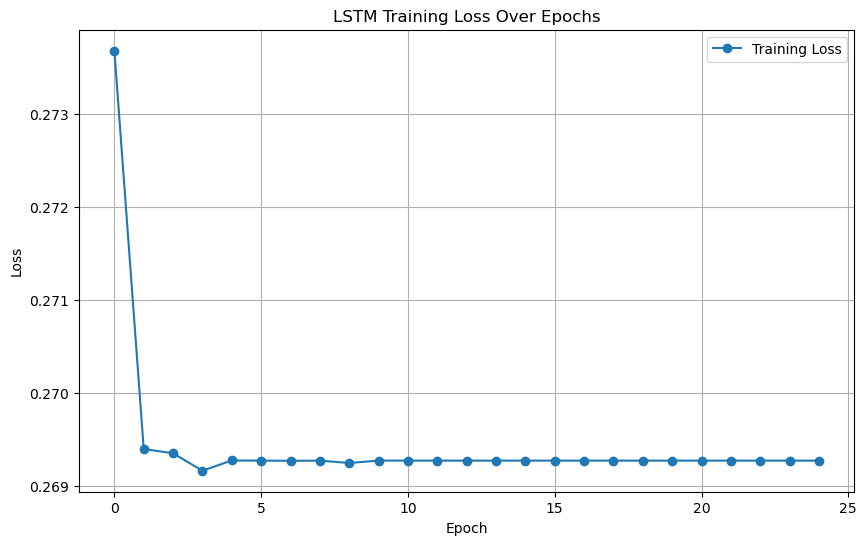

In [8]:
plot_training_loss(losses_elmon)

In [9]:
def calculate_accuracy_elman_rnn(model, X_test, y_test, threshold=0.02):

    
    total_test_points = 0
    correct_predictions = 0
    hidden_size = model.W_hh.out_features 

    for X_batch, Y_true in zip(X_test, y_test):
        hidden_state = torch.zeros(1, hidden_size, requires_grad=False, dtype=torch.float64)
        for time_step in range(X_batch.shape[0]):
            output, hidden_state = model(X_batch[time_step], hidden_state)
        
        is_correct = abs(output.item() - Y_true.item()) < threshold
        correct_predictions += is_correct
        total_test_points += 1

    accuracy = correct_predictions / total_test_points
    return accuracy


c:\Users\gupta\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([3350])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


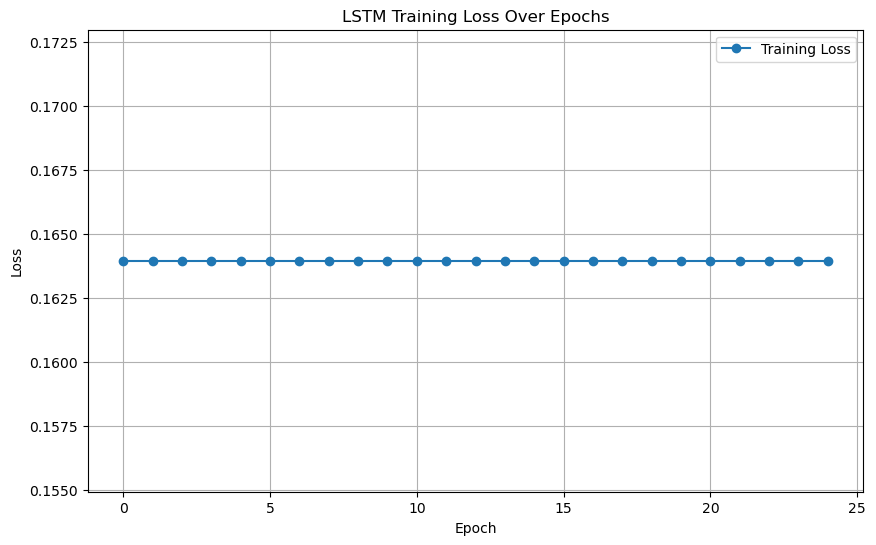

In [13]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.W_ix = nn.Linear(input_size, hidden_size, bias=False)
        self.W_ih = nn.Linear(hidden_size, hidden_size)

        self.W_ox = nn.Linear(input_size, hidden_size, bias=False)
        self.W_oh = nn.Linear(hidden_size, hidden_size)

        self.W_fx = nn.Linear(input_size, hidden_size, bias=False)
        self.W_fh = nn.Linear(hidden_size, hidden_size)

        self.W_cx = nn.Linear(input_size, hidden_size)
        self.W_ch = nn.Linear(hidden_size, hidden_size)

        self.W_hy = nn.Linear(hidden_size, output_size)

        self.double()
    
    def forward(self, X, H, C):
        f_t = torch.sigmoid(self.W_fx(X) + self.W_fh(H))
        i_t = torch.sigmoid(self.W_ix(X) + self.W_ih(H))
        o_t = torch.sigmoid(self.W_ox(X) + self.W_oh(H))     

        c_t_ = torch.sigmoid(self.W_cx(X))
        C = (f_t * C) + (i_t * c_t_)

        H = o_t * torch.sigmoid(C)

        output = self.W_hy(H)
        return output, H, C




In [14]:
losses_lstm = {}

loss_fun = nn.MSELoss()
lstmModel = LSTM(2, 10, 1)
optimizer = torch.optim.Adam(lstmModel.parameters(), lr=0.05)

for _ in tqdm(range(epoch)):
  losses = []
  for X_batch, Y_batch in zip(X_train, y_train):
    lstmModel.zero_grad()
    loss = 0
    hidden = torch.zeros(1, hidden_size, requires_grad=False, dtype=torch.float64)
    cell = torch.zeros(1, hidden_size, requires_grad=False, dtype=torch.float64)
    
    for i in range(X_batch.shape[0]):
      output, hidden, cell = lstmModel(X_batch[i, :], hidden, cell)
    loss = loss_fun(output, Y_batch)
    loss.backward()
    nn.utils.clip_grad_norm_(lstmModel.parameters(), 3)
    optimizer.step()
    losses.append(loss.detach().item())
  losses_lstm[_] = torch.tensor(losses).mean()

  0%|          | 0/25 [00:00<?, ?it/s]c:\Users\gupta\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 25/25 [04:31<00:00, 10.84s/it]


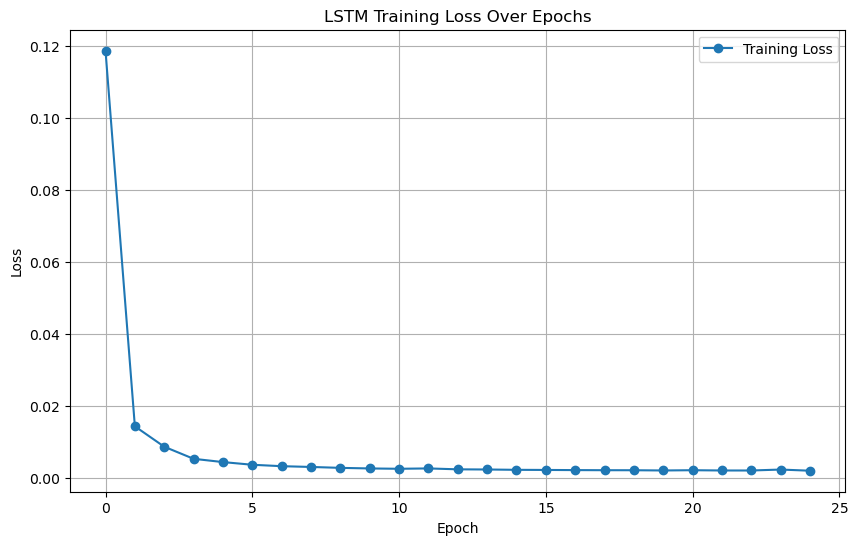

In [15]:
plot_training_loss(losses_lstm)

In [16]:
def calculate_lstm_accuracy(model, X_test, y_test, hidden_size, threshold=0.02):

    total_test_points = 0
    correct_predictions = 0
    
    # Ensure the model is in evaluation mode
    model.eval()

    with torch.no_grad():  # Disable gradient computation for efficiency
        for X_, Y_ in zip(X_test, y_test):
            # Initialize hidden and cell states
            hidden_state = torch.zeros(1, hidden_size, requires_grad=False, dtype=torch.float64)
            cell_state = torch.zeros(1, hidden_size, requires_grad=False, dtype=torch.float64)
            
            # Sequentially pass each time step of the input through the model
            for i in range(X_.shape[0]):
                output, hidden_state, cell_state = model(X_[i, :], hidden_state, cell_state)
            
            # Check if the prediction is within the threshold
            if abs(output.item() - Y_.item()) < threshold:
                correct_predictions += 1
            total_test_points += 1

    # Calculate and return the accuracy
    accuracy = correct_predictions / total_test_points
    return accuracy


In [17]:
# GRU Model Definition
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        
        # Define gates without bias for input and with bias for hidden
        self.W_z = nn.Linear(input_size, hidden_size, bias=False)
        self.W_zh = nn.Linear(hidden_size, hidden_size)
        self.W_r = nn.Linear(input_size, hidden_size, bias=False)
        self.W_rh = nn.Linear(hidden_size, hidden_size)
        self.W = nn.Linear(input_size, hidden_size, bias=False)
        self.W_h = nn.Linear(hidden_size, hidden_size, bias=False)

        # Output layer
        self.output_layer = nn.Linear(hidden_size, output_size)

        # Ensure the model uses double precision for weights
        self.double()
    
    def forward(self, input, hidden_state):
        # Update gate
        z_t = torch.sigmoid(self.W_z(input) + self.W_zh(hidden_state))
        
        # Reset gate
        r_t = torch.sigmoid(self.W_r(input) + self.W_rh(hidden_state))
        
        # New gate
        h_t_ = torch.tanh(self.W(input) + self.W_h(r_t * hidden_state))
        
        # Final hidden state
        h_t = (1 - z_t) * hidden_state + z_t * h_t_

        # Output
        output = self.output_layer(h_t)
        return output, h_t


In [18]:
# Initialize empty dictionary to store training loss history for GRU
losses_gru = {}
gruModel = GRUModel(2, 10, 1)
# Loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(gruModel.parameters(), lr=0.001)

# Training loop
for _ in tqdm(range(epoch)):
    losses = []

    for X_batch, Y_batch in zip(X_train, y_train):
        # Reset gradients
        gruModel.zero_grad()

      # Before the training loop
        X_batch = X_batch.double()  # Convert input data to double
        Y_batch = Y_batch.double()  # Convert target data to double

        # When initializing the hidden state
        hidden = torch.zeros(1, hidden_size, requires_grad=False, dtype=torch.float64)  # Ensure hidden is also double

        
        # Process each time step
        for i in range(X_batch.shape[0]):
            output, hidden = gruModel(X_batch[i], hidden)
        
        # Compute loss
        loss = loss_function(output, Y_batch)
        
        # Backpropagation
        loss.backward()
        
        # Gradient clipping
        nn.utils.clip_grad_norm_(gruModel.parameters(), 3)
        
        # Update model parameters
        optimizer.step()
        
        # Store loss
        losses.append(loss.item())
    
    # Store the average loss for the epoch
    losses_gru[_] = np.mean(losses)

100%|██████████| 25/25 [03:54<00:00,  9.38s/it]


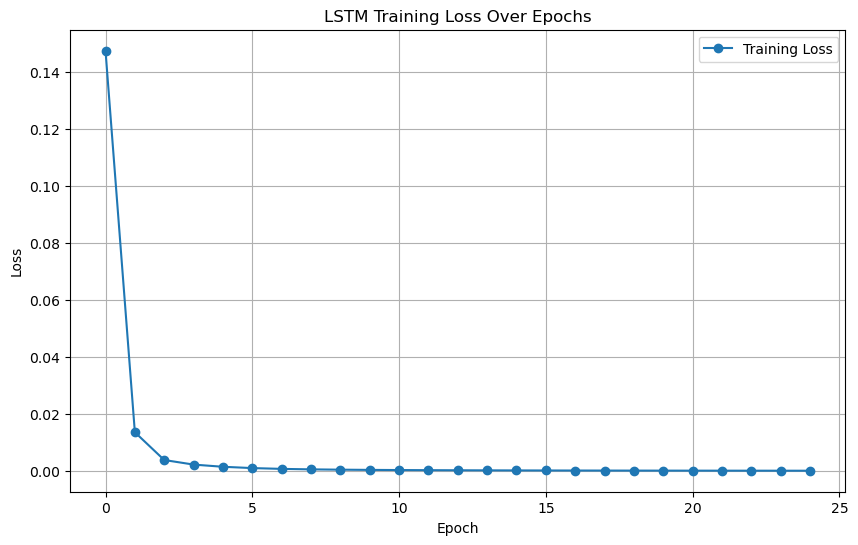

In [19]:
plot_training_loss(losses_gru)

In [20]:
def calculate_gru_accuracy(model, X_test, y_test, hidden_size, threshold=0.02):
    total_test_points = 0
    correct_predictions = 0
    for X_batch, Y_target in zip(X_test, y_test):
        hidden = torch.zeros(1, hidden_size, requires_grad=False, dtype=torch.float64)
        output = 0
        for i in range(X_batch.shape[0]):
            output, hidden = model(X_batch[i].unsqueeze(0), hidden)
        if abs(output.item() - Y_target.item()) < threshold:
            correct_predictions += 1
        total_test_points += 1
    accuracy = correct_predictions / total_test_points
    return accuracy


In [21]:
ElmanRNN_accuracy = calculate_accuracy_elman_rnn(elmanModel, X_test, y_test)
print(f"Elmon Accuracy: {ElmanRNN_accuracy:.4f}")
lstm_accuracy = calculate_lstm_accuracy(lstmModel, X_test, y_test, hidden_size)
print(f"LSTM Accuracy: {lstm_accuracy:.4f}")
gru_accuracy = calculate_gru_accuracy(gruModel, X_test, y_test, 10)
print(f"GRU Accuracy: {gru_accuracy:.4f}")


Elmon Accuracy: 0.0339
LSTM Accuracy: 0.6279
GRU Accuracy: 0.9467


In [ ]:
prediction = torch.ones(len(y_train))
losses_baseline = {}
loss_fun = nn.MSELoss()
for _ in range(epoch):
    losses = []
    for Y in y_train:        
        loss = loss_fun(prediction, Y)
        losses.append(loss.item())
    losses_baseline[_] = np.array(losses).mean()

plot_training_loss(losses_baseline)

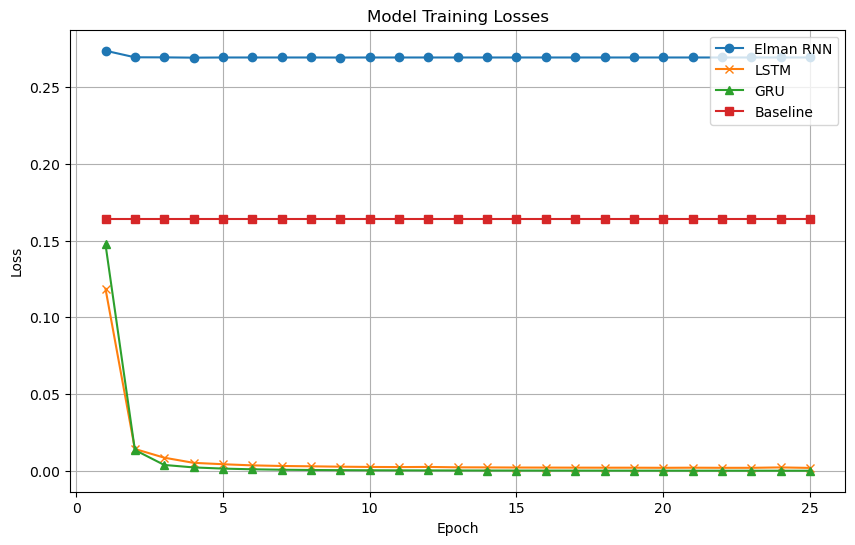

In [24]:
import matplotlib.pyplot as plt
import numpy as np

def plot_model_losses(losses_elman, losses_lstm, losses_gru, losses_baseline):

    plt.figure(figsize=(10, 6))

    # Convert dictionary values to lists for plotting
    elman_losses = list(losses_elman.values())
    lstm_losses = list(losses_lstm.values())
    gru_losses = list(losses_gru.values())
    baseline_losses = list(losses_baseline.values())

    epochs = range(1, len(elman_losses) + 1)

    plt.plot(epochs, elman_losses, label='Elman RNN', marker='o')
    plt.plot(epochs, lstm_losses, label='LSTM', marker='x')
    plt.plot(epochs, gru_losses, label='GRU', marker='^')
    plt.plot(epochs, baseline_losses, label='Baseline', marker='s')

    plt.title('Model Training Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.show()


plot_model_losses(losses_elmon, losses_lstm, losses_gru, losses_baseline)
